In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from PIL import Image as PILImage
from io import BytesIO

def notebook_dp_image(path: str, dim: set) -> None:
    img = PILImage.open(path)
    resized_img = img.resize(dim)  # (Width, Height)
    buffer = BytesIO()
    resized_img.save(buffer, format='PNG')
    display(Image(data=buffer.getvalue()))

_p227~259까지_

# CNN

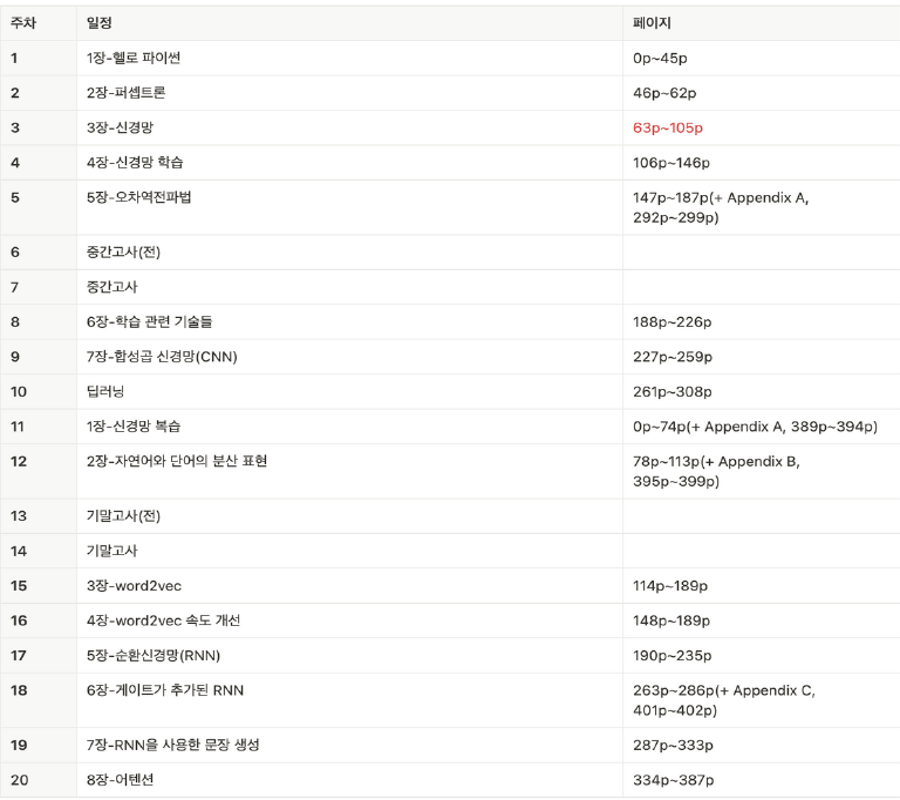

In [2]:
notebook_dp_image('./images/curriculum.png', (900,800))

---

## 왜 CNN을 사용?

> 합성곱을 쓰면 affine거칠때 손실되는(보통 flatten이 되어서) 공간적 정보를 레이어들을 거쳐도 유지할 수 있다.

## 작동 기본 개념들



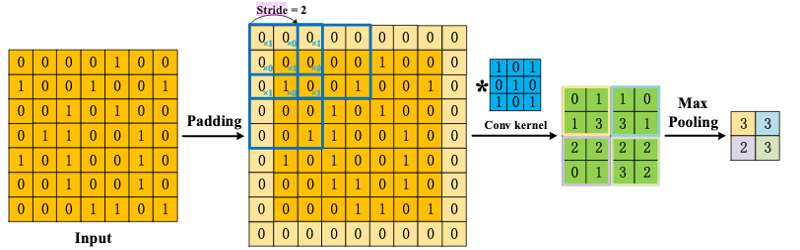

In [3]:
notebook_dp_image('./images/W9/cnn-base.png', (800,250))

- **filter / kernel**: 어떤 형태의 정보/주파수를 추출/변형할지 결정
- **stride**: 커널이 인풋이랑 합성곱을 할때마다 이동하는 거리
- **padding**: (optional) conv할시에 줄어드는 output을 보간하기 위해 사용 (보통 0으로 패딩함)
- **(max, min, avg) pooling**: 영상을 NxN으로 쪼개서 그 영역 안에서 한 값 고르는거 (영상 정보 압축/응축 느낌, 여기서는 최대값만)
- **bias (편향)**: 앞에서 봤던 DNN의 bias와 역할 같음. 최종 픽셀 값들에다 걍 원하는 값만큼 더해주면 됨 (위 그림에는 없음)

3차원 conv.같은 경우는 3x3x3커널을 쓸 경우:

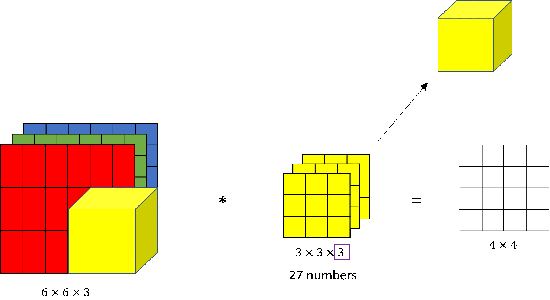

In [4]:
notebook_dp_image('./images/W9/conv3d.png', (550, 300))

깊이(RGB)는 인풋과 커널 모두 같으니 그 방향 차원은 사라짐, 2차원으로 출력이 나옴.

**extra:** 아닌 경우에는(커널이 인풋보다 모든 차원 면에서 더 작음) 다음과 같이 나옴:

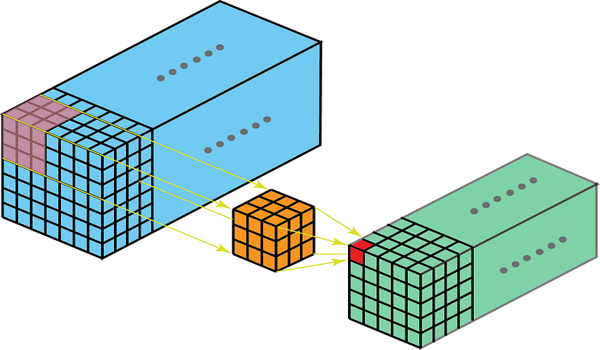

In [5]:
notebook_dp_image('./images/W9/conv3d2.png', (600,350))

한 입력에 대하여 conv를 여러번 돌릴수도 있다. 이렇게 하면 한 레이어 안에서 여러 시점들의 정보를 추출해낼 수 있음. 이 다른 시점들의 정보를 아웃풋의 depth필드 안에 저장하는 방식.

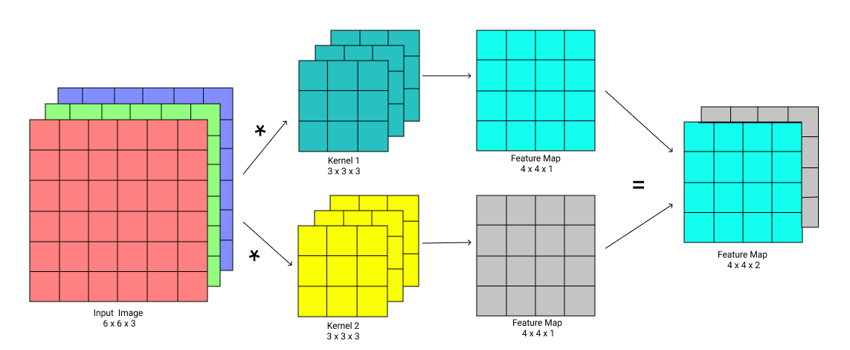

In [6]:
notebook_dp_image('./images/W9/conv3d3.png', (850,350))

위 그림은 사실상:
$$
(6 \times 6 \times 3) * (3 \times 3 \times 3 \times 2) \to (4 \times 4 \times 2)
$$

또 여기에 batch처리도 더해서 인풋 여러개를 한번에 처리할 수 있게 할 수 있음. 그래서 지금까지 다 합해보면:
$$
(N_{batch size} \times 6 \times 6 \times 3) * (3 \times 3 \times 3 \times 2) +  b \to (N_{batch size} \times 4 \times 4 \times 2)
$$

img proc에서는 $N \times W \times H \times \text{Ch}$로 표현하는게 관례

다음은 가장 대표적인 처리 모델인 VGG-16의 형태

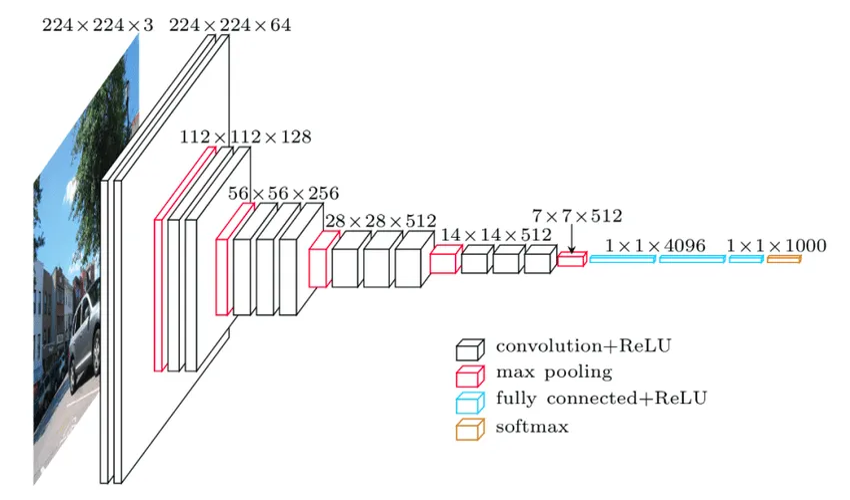

In [7]:
notebook_dp_image('./images/W9/vgg.png', (850,500))

채널이 곧 사진의 특징 하나하나를 의미하는거니, 레이어를 거칠수록 이미지 크기는 줄어들고 잡아낸 특징은 많아짐을 볼 수 있음.

최종적으로는 4096가지의 raw특징을 잡아냄. 그걸 최종 affine거쳐 결론도출

### `im2col` 사용하기

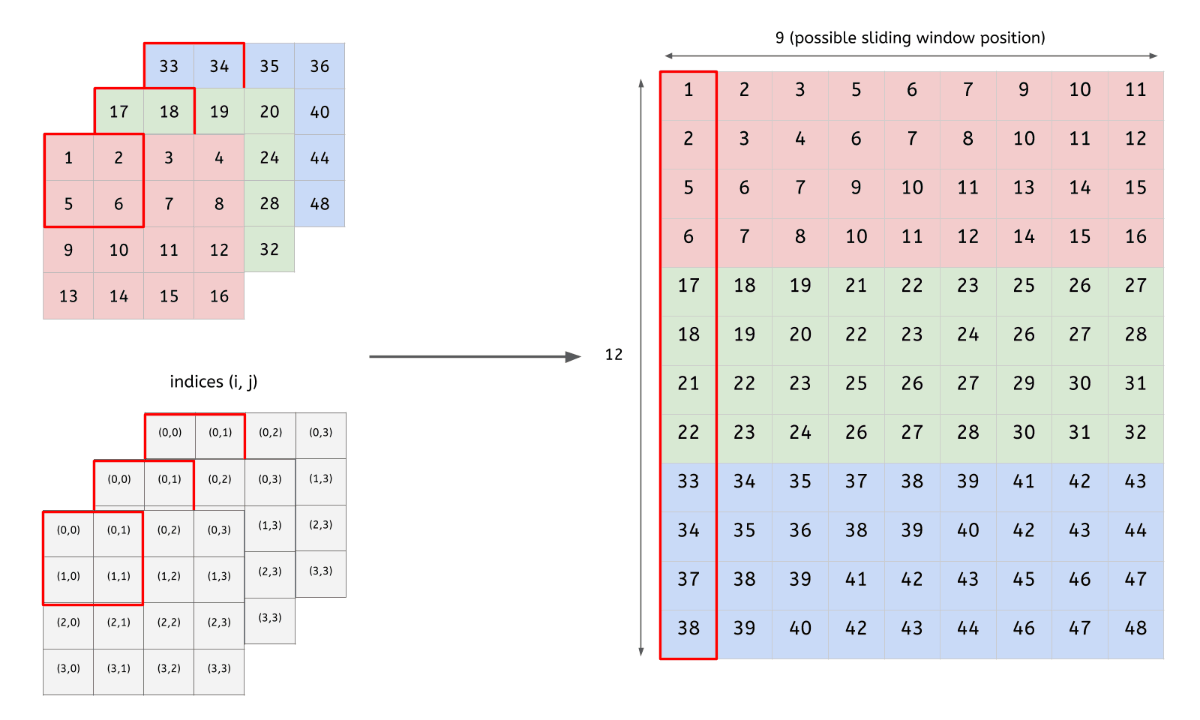

In [8]:
notebook_dp_image('./images/W9/im2col.gif', (1200, 720))

## 구현하기

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
print(tf.config.list_physical_devices('GPU'))

2025-05-07 02:48:47.171726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746553727.242654    1277 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746553727.263619    1277 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746553727.422607    1277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746553727.422657    1277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746553727.422659    1277 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 채널위한 차원 추가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# one-hot vectors로 변환환
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 10))

In [11]:
# functional API사용
# note: conv레이어 2개에 오버피팅 방지 위한 드롭아웃 2개 적용용
inputs = Input(shape=(28, 28, 1), name="input_layer")

x = layers.Conv2D(32, (3, 3), activation="relu", name="conv1")(inputs)
x = layers.Conv2D(64, (3, 3), activation="relu", name="conv2")(x)
x = layers.MaxPooling2D((2, 2), name="maxpool")(x)
x = layers.Dropout(0.25, name="dropout1")(x)

x = layers.Flatten(name="flatten")(x)
x = layers.Dense(128, activation="relu", name="affine1")(x)
x = layers.Dropout(0.5, name="dropout2")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model = Model(inputs=inputs, outputs=outputs, name="mnist_cnn_functional")

# 모델 컴파일일
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

I0000 00:00:1746553730.217691    1277 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:2b:00.0, compute capability: 6.1


Model: "mnist_cnn_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool (MaxPooling2D)          │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ affine1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 중간 레이어를 출력값으로 가지는 별도의 모델 정의의
conv1_intermediate = Model(
    inputs=model.input, outputs=model.get_layer('conv1').output)
conv2_intermediate = Model(
    inputs=model.input, outputs=model.get_layer('conv2').output)

---

In [ ]:
# 훈련
model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=12,
    validation_split=0.1
)

# 테스트
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/12


I0000 00:00:1746553732.189848    2368 service.cc:152] XLA service 0x7fb0e000bef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746553732.189880    2368 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-05-07 02:48:52.223131: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746553732.368384    2368 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-07 02:48:52.844946: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[128,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,26,26]{3,2,1,0} %bitcast.7100, f32[64,32,3,3]{3,2,1,0} %bitcast.6651, f32[64]{0} %bitcast.7160), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBias

 22/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4219 - loss: 1.7289

I0000 00:00:1746553734.827812    2368 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8332 - loss: 0.5211

2025-05-07 02:48:58.207830: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[112,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[112,32,26,26]{3,2,1,0} %bitcast.7100, f32[64,32,3,3]{3,2,1,0} %bitcast.6651, f32[64]{0} %bitcast.7160), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="mnist_cnn_functional_1/conv2_1/convolution" source_file="/home/maxjo/Projects/DaeNaMu/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8349 - loss: 0.5161

2025-05-07 02:49:00.097400: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[128,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,26,26]{3,2,1,0} %bitcast.516, f32[64,32,3,3]{3,2,1,0} %bitcast.523, f32[64]{0} %bitcast.525), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="mnist_cnn_functional_1/conv2_1/convolution" source_file="/home/maxjo/Projects/DaeNaMu/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-07 02:49:00.588257: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted p

422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8351 - loss: 0.5155 - val_accuracy: 0.9858 - val_loss: 0.0550
Epoch 2/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9708 - loss: 0.0949 - val_accuracy: 0.9893 - val_loss: 0.0406
Epoch 3/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9782 - loss: 0.0711 - val_accuracy: 0.9890 - val_loss: 0.0420
Epoch 4/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9829 - loss: 0.0549 - val_accuracy: 0.9907 - val_loss: 0.0348
Epoch 5/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9851 - loss: 0.0484 - val_accuracy: 0.9905 - val_loss: 0.0343
Epoch 6/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9862 - loss: 0.0428 - val_accuracy: 0.9912 - val_loss: 0.0336
Epoch 7/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9884 - loss: 0.0362 - val_accuracy: 0.9905 - val_loss: 0.0392
Epoch 8/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9897 - loss: 0.0322 - val_accuracy: 0.9903 - val

2025-05-07 02:49:36.380389: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[32,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,26,26]{3,2,1,0} %bitcast.516, f32[64,32,3,3]{3,2,1,0} %bitcast.523, f32[64]{0} %bitcast.525), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="mnist_cnn_functional_1/conv2_1/convolution" source_file="/home/maxjo/Projects/DaeNaMu/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0364

2025-05-07 02:49:37.388811: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[16,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,26,26]{3,2,1,0} %bitcast.516, f32[64,32,3,3]{3,2,1,0} %bitcast.523, f32[64]{0} %bitcast.525), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="mnist_cnn_functional_1/conv2_1/convolution" source_file="/home/maxjo/Projects/DaeNaMu/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9893 - loss: 0.0363
Test accuracy: 0.9916


---

### 중간 단계들 살펴보기

conv1과 2를 두어 만들었는데 각 레이어의 커널 거쳐서 나온 결과를 관찰해보았다.

위의 `conv1_intermediate`, `conv2_intermediate`를 정의해서 따로 출력시켜 관찰할 수 있음!

In [14]:
def show_layer(layer) -> None:
    intermediate_out = layer.predict(x_test[:1, ...])

    # shape (26,26), each pixel = mean over 32 channels
    intermediate_out = intermediate_out[0].mean(axis=2)

    plt.imshow(intermediate_out, cmap='gray')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


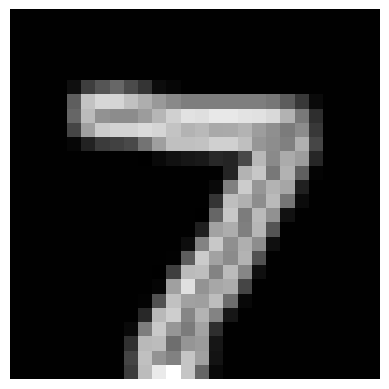

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


2025-05-07 02:49:38.017322: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[1,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,26,26]{3,2,1,0} %bitcast.88, f32[64,32,3,3]{3,2,1,0} %bitcast.95, f32[64]{0} %bitcast.97), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2_1/convolution" source_file="/home/maxjo/Projects/DaeNaMu/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


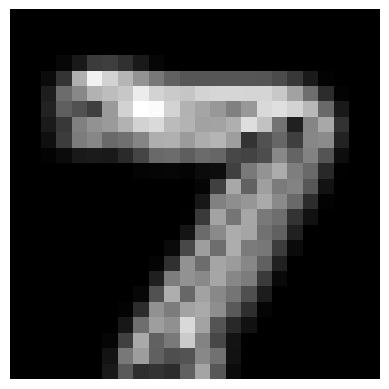

In [15]:
show_layer(conv1_intermediate)
show_layer(conv2_intermediate)